In [1]:
import pandas as pd 
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [90]:
# Import from uploaded files 
base_dir = './dataset/'
#base_dir = '/content/drive/MyDrive/ShellBy AI/'


demand_history = pd.read_csv(base_dir + 'Demand_History.csv')
prophet_18 = pd.read_csv(base_dir + 'prophet_2018.csv')
neural_prophet_18 = pd.read_csv(base_dir +'demand_predictios_neural_prophet_2018.csv')
lg_18 = pd.read_csv(base_dir + 'demand_predictios_LG_2018.csv')
sarimax_18 = pd.read_csv(base_dir + 'demand_predictios_SARIMAX_2018.csv')

In [3]:
def get_preds(multiprocess_forecast, year=2018):
  ids = list(set(multiprocess_forecast.dp_id.tolist()))
  preds = []
  if year == 2018:
    for i in ids:
      preds.append(multiprocess_forecast[multiprocess_forecast['dp_id'] == ids[i]].iloc[8].yhat_upper)
  elif(year == 2019 or year == 2020):
    for i in ids:
      preds.append([multiprocess_forecast[multiprocess_forecast['dp_id'] == ids[i]].iloc[9].yhat_upper,multiprocess_forecast[multiprocess_forecast['dp_id'] == ids[i]].iloc[10].yhat_upper])
  return preds

In [93]:
preds = get_preds(prophet_18, year=2018)
prophet_18 = pd.DataFrame(preds,columns=['preds'])
neural_prophet_18 = neural_prophet_18.rename(columns={'2018':'preds'})

In [105]:
train_predictions = np.concatenate([prophet_18.preds[:,None], neural_prophet_18.preds[:,None], lg_18.preds[:,None], sarimax_18.preds[:,None]], axis=1)

C:\Users\Tolis\AppData\Local\Temp\ipykernel_11480\4046217341.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_predictions = np.concatenate([prophet_18.preds[:,None], neural_prophet_18.preds[:,None], lg_18.preds[:,None], sarimax_18.preds[:,None]], axis=1)


In [106]:
def objective(weights):
    #Calculate the score of mean absolute error of predictions
    y_ens = np.average(train_predictions, axis=1, weights=weights)
    return (demand_history['2018']- y_ens).abs().sum()

In [107]:
from scipy.optimize import minimize

results_list = []    # a list to store the best score of each round
weights_list = []    # a list to store the best weights of each round

for k in tqdm(range(100)):
    # I randomly set the initial weights from which the algorithm will try searching a minima    
    w0 = np.random.uniform(size=train_predictions.shape[1])

    # I define bounds, i.e. lower and upper values of weights.
    # I want the weights to be between 0 and 1.
    bounds = [(0,1)] * train_predictions.shape[1]

    # I set some constraints. Here, I want the sum of the weights to be equal to 1
    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    # I can now search for the best weights
    res = minimize(objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    # I save the best score and the best weights of
    # this round in their respective lists
    results_list.append(res.fun)
    weights_list.append(res.x)

# After running all the rounds, I extract the best score
# and the corresponding weights
best_score = np.min(results_list)    
best_weights = weights_list[results_list.index(best_score)]

print('\nOptimized weights:')
print('Prophet: {:.4f}'.format(best_weights[0]))
print('NeuralProphet: {:.4f}'.format(best_weights[1]))
print('Linear Regression: {:.4f}'.format(best_weights[2]))
print('SARIMax Regression: {:.4f}'.format(best_weights[3]))
print('Best score: {:.4f}'.format(best_score))

  0%|          | 0/100 [00:00<?, ?it/s]


Optimized weights:
Prophet: 0.0000
NeuralProphet: 0.4516
Linear Regression: 0.5484
SARIMax Regression: 0.0000
Best score: 24450.0467


In [108]:
# Testing the neural prophet and prophet version
demand_evaluate_test =  prophet_18.preds*best_weights[0] + neural_prophet_18.preds*best_weights[1] + lg_18.preds*best_weights[2]

RMSE: 10.572476544215252
MAE: 24449.639140853214


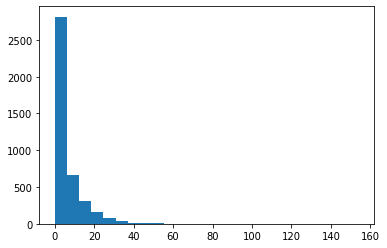

In [109]:

# Calculate RMSE
rmse = sqrt(mean_squared_error(demand_history['2018'], demand_evaluate_test)) 
print(f"RMSE: {rmse}")

# The sum of the mean absolute error of the demand
sum_of_mae = (demand_evaluate_test-demand_history['2018']).abs().sum()
print(f'MAE: {sum_of_mae}')

# mape = np.mean(np.abs((demand_history['2018'] - demand_evaluate_test) /demand_history['2018'])) * 100
# print(f"MAPE: {mape}")


# Histogram of the Mean Absolute Error
plt.hist((demand_evaluate_test-demand_history['2018']).abs(), bins = 25)
plt.show()

In [113]:
ensemble_np_p_2019_2020 = prophet_2019_2020

In [114]:
ensemble_np_p_2019_2020['2019'] =  prophet_2019_2020['2019']*best_weights[0] + neural_prophet_2019_2020['2019']*best_weights[1] + lg_2019_2020['2019']*best_weights[2] 
ensemble_np_p_2019_2020['2020'] =  prophet_2019_2020['2020']*best_weights[0] + neural_prophet_2019_2020['2020']*best_weights[1] + lg_2019_2020['2020']*best_weights[2] 

In [116]:
ensemble_np_p_2019_2020.to_csv('ensemble_2019_2020.csv', index=False)